In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

## DATABASE CONNECTION

In [2]:
DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

# Tester la connexion
try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


## Import Data

In [3]:
query = """
SELECT 
w.date,
EXTRACT(HOUR FROM w.hour) AS hour_of_day,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date, hour_of_day
ORDER BY w.date, hour_of_day;
"""

weather = pd.read_sql(sqla.text(query), connection)

query = """
    SELECT 
        t.departure_date AS date,
        EXTRACT(HOUR FROM t.real_time_departure) AS hour_of_day,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date, hour_of_day
    ORDER BY t.departure_date, hour_of_day;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
    SELECT * FROM TYPE_DAY;
"""

type_day = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date", "hour_of_day"], how="inner")

merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])

merged_df['date'] = merged_df['date'].dt.dayofyear

merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

# Drop the original 'date' column
merged_df.drop(columns=['date'], inplace=True)

print(merged_df.shape)

(90390, 16)


## Testing with Classifier

In [4]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier,StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier,LogisticRegression,RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
def dummy_train(xtrain,xtest,ytrain,ytest,model, print_results=True):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print("Model",model)
    print("Accuracy",accuracy_score(ytest,ypred))
    if print_results:
        print("Confusion Matrix\n",confusion_matrix(ytest,ypred))
        print("Classification Report\n",classification_report(ytest,ypred))


## Only the weather dummy test

In [ ]:
x = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y = merged_df["avg_delay_departure"]

median_y = y.median()
print(median_y)

new_y = y.apply(lambda x: 1 if x > median_y else 0)

xtrain,xtest,ytrain,ytest = train_test_split(x,new_y,test_size=0.2,random_state=42)

models = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),ExtraTreesClassifier(),BaggingClassifier(),GaussianNB(),SGDClassifier(),LogisticRegression(),RidgeClassifier(),SVC(),MLPClassifier()]

for model in models:
    dummy_train(xtrain,xtest,ytrain,ytest,model)

116.14999774464917
Model KNeighborsClassifier()
Accuracy 0.5769443522513552
Confusion Matrix
 [[5237 3801]
 [3847 5193]]
Classification Report
               precision    recall  f1-score   support

           0       0.58      0.58      0.58      9038
           1       0.58      0.57      0.58      9040

    accuracy                           0.58     18078
   macro avg       0.58      0.58      0.58     18078
weighted avg       0.58      0.58      0.58     18078

Model DecisionTreeClassifier()
Accuracy 0.5809270937050559
Confusion Matrix
 [[5302 3736]
 [3840 5200]]
Classification Report
               precision    recall  f1-score   support

           0       0.58      0.59      0.58      9038
           1       0.58      0.58      0.58      9040

    accuracy                           0.58     18078
   macro avg       0.58      0.58      0.58     18078
weighted avg       0.58      0.58      0.58     18078

Model RandomForestClassifier()
Accuracy 0.6426595862374156
Confusion Matrix

C:\Users\leiya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leiya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leiya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

## Testing Date against day_sin , day_cos

In [18]:
query = """
SELECT 
w.date,
EXTRACT(HOUR FROM w.hour) AS hour_of_day,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date, hour_of_day
ORDER BY w.date, hour_of_day;
"""

weather = pd.read_sql(sqla.text(query), connection)

query = """
    SELECT 
        t.departure_date AS date,
        EXTRACT(HOUR FROM t.real_time_departure) AS hour_of_day,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date, hour_of_day
    ORDER BY t.departure_date, hour_of_day;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
    SELECT * FROM TYPE_DAY;
"""

type_day = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date", "hour_of_day"], how="inner")

merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])

merged_df['date'] = merged_df['date'].dt.dayofyear

merged_df2 = merged_df.copy()

merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

# Drop the original 'date' column
merged_df.drop(columns=['date'], inplace=True)

print(merged_df.shape)

(90390, 16)


In [ ]:
x = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
x_bis = merged_df2[["date","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

median_y = y.median()

new_y = y.apply(lambda x: 1 if x > median_y else 0)

accuracy_x = []
accuracy_x_bis = []

for i in range (20):
    xtrain,xtest,ytrain,ytest = train_test_split(x,new_y,test_size=0.2,random_state=i)
    xtrain_bis,xtest_bis,ytrain_bis,ytest_bis = train_test_split(x_bis,new_y,test_size=0.2,random_state=i)
    model = RandomForestClassifier()
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    accuracy_x.append(accuracy_score(ytest,ypred))
    model = RandomForestClassifier()
    model.fit(xtrain_bis,ytrain_bis)
    ypred = model.predict(xtest_bis)
    accuracy_x_bis.append(accuracy_score(ytest_bis,ypred))

print("Accuracy with date sin and cos",np.mean(accuracy_x))
print("Accuracy without date sin and cos",np.mean(accuracy_x_bis))



Accuracy with date sin and cos 0.6872607589335102
Accuracy without date sin and cos 0.6767811704834605


## Only using the hours and date dummies test

In [20]:
x = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

median_y = y.median()
print(median_y)

new_y = y.apply(lambda x: 1 if x > median_y else 0)

xtrain,xtest,ytrain,ytest = train_test_split(x,new_y,test_size=0.2,random_state=42)

models = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),ExtraTreesClassifier(),BaggingClassifier(),GaussianNB(),SGDClassifier(),LogisticRegression(),RidgeClassifier(),SVC(),MLPClassifier()]

for model in models:
    dummy_train(xtrain,xtest,ytrain,ytest,model)

116.14999774464917
Model KNeighborsClassifier()
Accuracy 0.6945458568425711
Confusion Matrix
 [[6156 2882]
 [2640 6400]]
Classification Report
               precision    recall  f1-score   support

           0       0.70      0.68      0.69      9038
           1       0.69      0.71      0.70      9040

    accuracy                           0.69     18078
   macro avg       0.69      0.69      0.69     18078
weighted avg       0.69      0.69      0.69     18078

Model DecisionTreeClassifier()
Accuracy 0.6677729837371391
Confusion Matrix
 [[6543 2495]
 [3511 5529]]
Classification Report
               precision    recall  f1-score   support

           0       0.65      0.72      0.69      9038
           1       0.69      0.61      0.65      9040

    accuracy                           0.67     18078
   macro avg       0.67      0.67      0.67     18078
weighted avg       0.67      0.67      0.67     18078

Model RandomForestClassifier()
Accuracy 0.686856953202788
Confusion Matrix


## With all the parameters

In [ ]:
x = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure","day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

median_y = y.median()

new_y = y.apply(lambda x: 1 if x > median_y else 0)


xtrain,xtest,ytrain,ytest = train_test_split(x,new_y,test_size=0.2,random_state=42)

models = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),ExtraTreesClassifier(),BaggingClassifier(),GaussianNB(),SGDClassifier(),LogisticRegression(max_iter = 50000),RidgeClassifier(),SVC(),MLPClassifier()]

for model in models:
    dummy_train(xtrain,xtest,ytrain,ytest,model)


Model KNeighborsClassifier()
Accuracy 0.6443190618431243
Confusion Matrix
 [[5946 3092]
 [3338 5702]]
Classification Report
               precision    recall  f1-score   support

           0       0.64      0.66      0.65      9038
           1       0.65      0.63      0.64      9040

    accuracy                           0.64     18078
   macro avg       0.64      0.64      0.64     18078
weighted avg       0.64      0.64      0.64     18078

Model DecisionTreeClassifier()
Accuracy 0.7282332116384556
Confusion Matrix
 [[6605 2433]
 [2480 6560]]
Classification Report
               precision    recall  f1-score   support

           0       0.73      0.73      0.73      9038
           1       0.73      0.73      0.73      9040

    accuracy                           0.73     18078
   macro avg       0.73      0.73      0.73     18078
weighted avg       0.73      0.73      0.73     18078

Model RandomForestClassifier()
Accuracy 0.8243168492089833
Confusion Matrix
 [[7355 1683]
 [14

C:\Users\leiya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model LogisticRegression()
Accuracy 0.6046575948666888
Confusion Matrix
 [[5242 3796]
 [3351 5689]]
Classification Report
               precision    recall  f1-score   support

           0       0.61      0.58      0.59      9038
           1       0.60      0.63      0.61      9040

    accuracy                           0.60     18078
   macro avg       0.60      0.60      0.60     18078
weighted avg       0.60      0.60      0.60     18078

Model RidgeClassifier()
Accuracy 0.6046022790131652
Confusion Matrix
 [[5178 3860]
 [3288 5752]]
Classification Report
               precision    recall  f1-score   support

           0       0.61      0.57      0.59      9038
           1       0.60      0.64      0.62      9040

    accuracy                           0.60     18078
   macro avg       0.61      0.60      0.60     18078
weighted avg       0.61      0.60      0.60     18078

Model SVC()
Accuracy 0.5573072242504702
Confusion Matrix
 [[5154 3884]
 [4119 4921]]
Classification Rep

## Let's test now with 10 classes

In [ ]:
x = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure","day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

thresholds = np.quantile(y, np.linspace(0, 1, 11))
print("Thresholds (deciles):", thresholds)

y_binned = pd.cut(y, bins=thresholds, include_lowest=True, labels=range(10))

xtrain,xtest,ytrain,ytest = train_test_split(x,y_binned,test_size=0.2,random_state=42)

models = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),ExtraTreesClassifier(),BaggingClassifier(),GaussianNB(),SGDClassifier(),LogisticRegression(max_iter=50000),RidgeClassifier(),SVC(),MLPClassifier()]

for model in models:
    dummy_train(xtrain,xtest,ytrain,ytest,model , print_results=False)

Thresholds (deciles): [-8.52236667e+04  5.02787794e+01  6.84227309e+01  8.40487318e+01
  9.96688172e+01  1.16149998e+02  1.34741261e+02  1.58619062e+02
  1.92223096e+02  2.62006373e+02  3.31200000e+04]
Model KNeighborsClassifier()
Accuracy 0.1912822214846775
Model DecisionTreeClassifier()
Accuracy 0.25804845668768667
Model RandomForestClassifier()
Accuracy 0.34777077110299814
Model AdaBoostClassifier()
Accuracy 0.2285651067595973
Model GradientBoostingClassifier()
Accuracy 0.25373382011284434
Model ExtraTreesClassifier()
Accuracy 0.34030313087730946
Model BaggingClassifier()
Accuracy 0.30384998340524394
Model GaussianNB()
Accuracy 0.16113508131430468
Model SGDClassifier()
Accuracy 0.15853523619869456


C:\Users\leiya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model LogisticRegression()
Accuracy 0.14570195818121473
Model RidgeClassifier()
Accuracy 0.16832614227237527
Model SVC()
Accuracy 0.13718331673857728
Model MLPClassifier()
Accuracy 0.13524726186525057


## 300 sec of delay of SNCB

In [32]:
x = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure","day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

y = y.apply(lambda x: 1 if x > 300 else 0)

print(f"Percentage of 1 in y: {y.sum() / len(y) * 100:.2f}%")
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

models = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),ExtraTreesClassifier(),BaggingClassifier(),GaussianNB(),SGDClassifier(),LogisticRegression(max_iter=50000),RidgeClassifier(),SVC(),MLPClassifier()]

for model in models:
    dummy_train(xtrain,xtest,ytrain,ytest,model , print_results=False)

Percentage of 1 in y: 7.56%
Model KNeighborsClassifier()
Accuracy 0.9207323819006528
Model DecisionTreeClassifier()
Accuracy 0.9119924770439208
Model RandomForestClassifier()
Accuracy 0.9385994025887819
Model AdaBoostClassifier()
Accuracy 0.931463657484235
Model GradientBoostingClassifier()
Accuracy 0.9348932404026994
Model ExtraTreesClassifier()
Accuracy 0.9415864586790574
Model BaggingClassifier()
Accuracy 0.9338975550392743
Model GaussianNB()
Accuracy 0.7056643434008186
Model SGDClassifier()
Accuracy 0.9235534904303574
Model LogisticRegression(max_iter=50000)
Accuracy 0.9242172806726408
Model RidgeClassifier()
Accuracy 0.9242172806726408
Model SVC()
Accuracy 0.9242172806726408
Model MLPClassifier()
Accuracy 0.9242172806726408


In [30]:
x = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure","day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

y = y.apply(lambda x: 1 if x > 180 else 0)

print(f"Percentage of 1 in y: {y.sum() / len(y) * 100:.2f}%")
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

models = [KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),ExtraTreesClassifier(),BaggingClassifier(),GaussianNB(),SGDClassifier(),LogisticRegression(max_iter=50000),RidgeClassifier(),SVC(),MLPClassifier()]

for model in models:
    dummy_train(xtrain,xtest,ytrain,ytest,model , print_results=False)

Percentage of 1 in y: 23.17%
Model KNeighborsClassifier()
Accuracy 0.7727624737249695
Model DecisionTreeClassifier()
Accuracy 0.7848766456466423
Model RandomForestClassifier()
Accuracy 0.8575616771766789
Model AdaBoostClassifier()
Accuracy 0.7910167053877641
Model GradientBoostingClassifier()
Accuracy 0.8040159309658148
Model ExtraTreesClassifier()
Accuracy 0.8584467308330568
Model BaggingClassifier()
Accuracy 0.8231552162849872
Model GaussianNB()
Accuracy 0.7297267396835934
Model SGDClassifier()
Accuracy 0.7670649408120367
Model LogisticRegression(max_iter=50000)
Accuracy 0.7668436773979422
Model RidgeClassifier()
Accuracy 0.7668989932514658
Model SVC()
Accuracy 0.7670649408120367
Model MLPClassifier()
Accuracy 0.7570527713242615


## Feature selection

                  Feature        Score
11                weekend  1274.020145
10                holiday   880.534287
2   avg_relative_humidity   403.339023
13            hour_of_day   376.605827
8                 day_sin   364.766941
12         day_after_rest   261.027238
9                 day_cos   156.608740
5      avg_wind_direction   101.230298
7            avg_pressure    85.505183
0         avg_temperature    81.426863
3       avg_precipitation    52.412030
6          avg_wind_speed    49.756195
4            avg_snowfall     0.722797
1            avg_dewpoint     0.152178


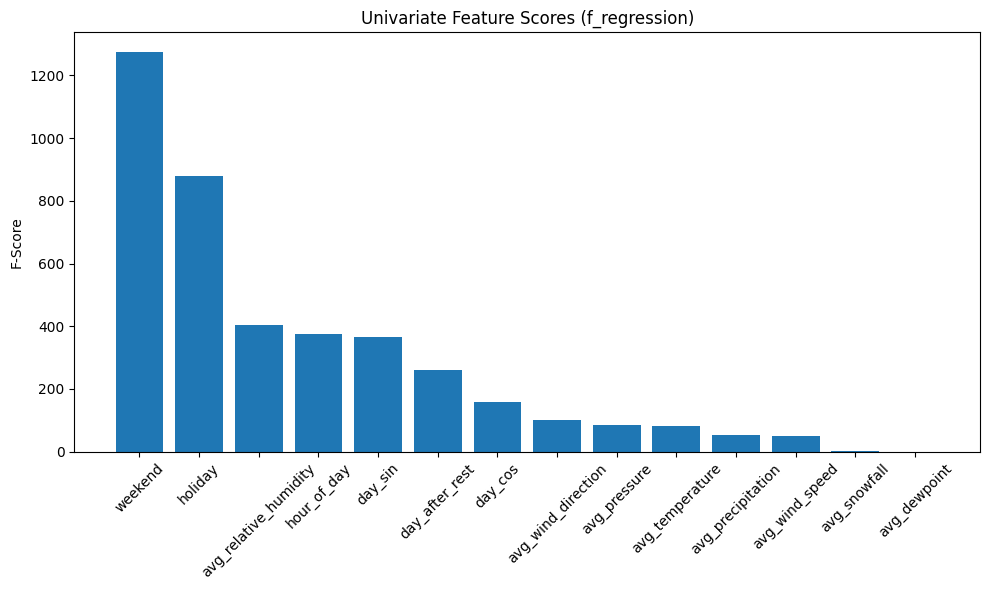

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(x, y)

feature_scores = pd.DataFrame({'Feature': x.columns,'Score': selector.scores_}).sort_values(by='Score', ascending=False)

print(feature_scores)

plt.figure(figsize=(10, 6))
plt.bar(feature_scores['Feature'], feature_scores['Score'])
plt.title("Univariate Feature Scores (f_regression)")
plt.xticks(rotation=45)
plt.ylabel("F-Score")
plt.tight_layout()
plt.show()

In [16]:
from sklearn.linear_model import ElasticNet


elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic_net.fit(x, y)

# Get selected features
selected_features = x.columns[np.abs(elastic_net.coef_) > 0]
print("Selected Features:", selected_features)

Selected Features: Index(['avg_dewpoint', 'avg_relative_humidity', 'avg_wind_direction',
       'avg_wind_speed', 'avg_pressure', 'day_sin', 'holiday', 'weekend',
       'hour_of_day'],
      dtype='object')


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

estimator = LinearRegression()

rfe = RFE(estimator, n_features_to_select=9)
rfe.fit(x, y)

selected_features = x.columns[rfe.support_]
print("Selected features (RFE):", selected_features)

Selected features (RFE): Index(['avg_temperature', 'avg_dewpoint', 'avg_relative_humidity',
       'avg_precipitation', 'avg_snowfall', 'day_sin', 'holiday', 'weekend',
       'day_after_rest'],
      dtype='object')


## Hyperparameter Tuning

In [ ]:
# On RandomForest

x = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure","day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

y = y.apply(lambda x: 1 if x < 180 else 0)


xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=42)

n_estimators = [10, 25, 50, 75, 100, 150]
max_depths = [2, 5, 10, 20,50,100, None]
methods = ['gini', 'entropy', 'log_loss']

best_score = 0
best_params = None
for n_estimator in n_estimators:
    for max_depth in max_depths:
        for method in methods:
            rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, criterion=method)
            rf.fit(xtrain, ytrain)
            ypred = rf.predict(xtest)
            score = accuracy_score(ytest, ypred)
            if score > best_score:
                best_score = score
                best_params = (n_estimator, max_depth, method)


print("Best score:", best_score)
print("Best params:", best_params)
            

Best score: 0.8564000442526828
Best params: (100, 50, 'gini')


## Adding the assumption strike

In [14]:
merged_df["strike"] = (merged_df["avg_delay_departure"] > 300).astype(int)
#mask = np.random.rand(len(merged_df)) < 0.01
#merged_df.loc[mask, "strike"] = 1 - merged_df.loc[mask, "strike"]
x = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure","day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day", "strike"]]

y = merged_df["avg_delay_departure"]
y = y.apply(lambda x: 1 if x > 180 else 0)

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=42)

rf = RandomForestClassifier(n_estimators=500, max_depth=50, criterion='gini')

rf.fit(xtrain, ytrain)

ypred = rf.predict(xtest)

print("Accuracy", accuracy_score(ytest, ypred))
print("Confusion Matrix\n", confusion_matrix(ytest, ypred))



Accuracy 0.8739904856731939
Confusion Matrix
 [[20376   388]
 [ 3029  3324]]


## Only with 9 features at each times

In [20]:
#Filtered techniques
x = merged_df[["avg_temperature", "avg_relative_humidity", "avg_wind_direction","day_sin","day_cos","holiday","weekend", "day_after_rest","hour_of_day"]]
y = merged_df["avg_delay_departure"]

y = y.apply(lambda x: 1 if x > 180 else 0)

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_mean = []

for train_index, test_index in kfold.split(x):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion='gini')

    rf.fit(xtrain, ytrain)

    ypred = rf.predict(xtest)

    accuracy_mean.append(accuracy_score(ytest, ypred))

print("Mean Accuracy", np.mean(accuracy_mean))

Mean Accuracy 0.8497621418298484


In [32]:
#Embedded techniques

x = merged_df[['avg_dewpoint', 'avg_relative_humidity', 'avg_wind_direction','avg_wind_speed', 'avg_pressure', 'day_sin', 'holiday', 'weekend','hour_of_day']]
y = merged_df["avg_delay_departure"]

y = y.apply(lambda x: 1 if x > 180 else 0)

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_mean = []

for train_index, test_index in kfold.split(x):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion='gini')

    rf.fit(xtrain, ytrain)

    ypred = rf.predict(xtest)

    accuracy_mean.append(accuracy_score(ytest, ypred))

print("Mean Accuracy", np.mean(accuracy_mean))


Mean Accuracy 0.8544971788914703


In [21]:
# Wrapper techniques

x = merged_df[['avg_dewpoint', 'avg_relative_humidity', 'avg_wind_direction','avg_wind_speed', 'avg_pressure', 'day_sin', 'holiday', 'weekend','hour_of_day']]
y = merged_df["avg_delay_departure"]

y = y.apply(lambda x: 1 if x > 180 else 0)

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_mean = []

for train_index, test_index in kfold.split(x):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion='gini')

    rf.fit(xtrain, ytrain)

    ypred = rf.predict(xtest)

    accuracy_mean.append(accuracy_score(ytest, ypred))

print("Mean Accuracy", np.mean(accuracy_mean))



Mean Accuracy 0.854862263524726


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

estimator = LinearRegression()

rfe = RFE(estimator, n_features_to_select=6)
rfe.fit(x, y)

selected_features = x.columns[rfe.support_]
print("Selected features (RFE):", selected_features)

Selected features (RFE): Index(['avg_wind_speed', 'avg_pressure', 'day_sin', 'holiday', 'weekend',
       'hour_of_day'],
      dtype='object')


In [27]:
x = merged_df[['day_cos', 'day_sin', 'holiday','weekend', 'hour_of_day']]
y = merged_df["avg_delay_departure"]

y = y.apply(lambda x: 1 if x > 180 else 0)

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_mean = []

for train_index, test_index in kfold.split(x):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion='gini')

    rf.fit(xtrain, ytrain)

    ypred = rf.predict(xtest)

    accuracy_mean.append(accuracy_score(ytest, ypred))

print("Mean Accuracy", np.mean(accuracy_mean))


Mean Accuracy 0.7805509459010953
